In [52]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
import time
import os
from dotenv import load_dotenv
os.environ["USE_PYGEOS"] = "0"
import napari_sparrow as nas
from spatialdata import read_zarr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import sample 
import scanpy as sc
import seaborn as sns
import anndata as ad
%run own_and_modified_functions.ipynb
warnings.simplefilter(action='ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
OUTPUT_DIR = '/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/A1-1'
sdata = read_zarr( os.path.join(  OUTPUT_DIR, 'sdata.zarr'  ) )
anndata = sc.read(OUTPUT_DIR + '/anndataNucA11') # reset original anndata
# delete anndata
del sdata.table
# create anndata
sdata.table = anndata

In [3]:
n_pca = np.count_nonzero(sdata.table.uns['pca']['variance_ratio'] > 0.01)
make_umap(sdata,n_PCAs=n_pca,n_neighbors=15) # umap only used for the visualization, does not have an effect on the annotation with 'score_genes'

In [4]:
path_mg = "/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/markerGeneListHL_othIm_endoSplit_portalLAM.csv"

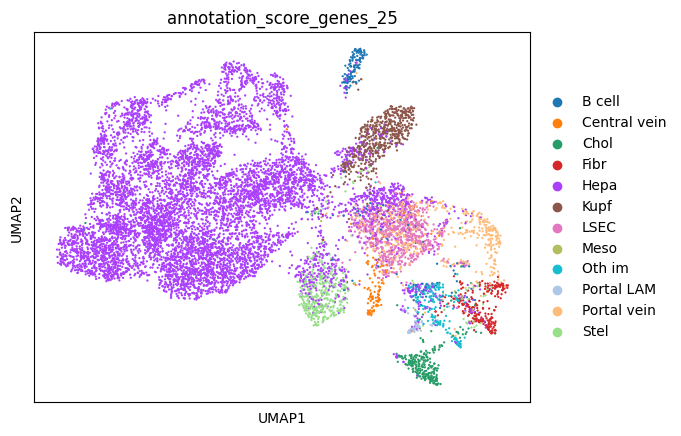

              annotation_score_genes_25
B cell                         1.807980
Central vein                   0.970787
Chol                           2.377984
Fibr                           2.048450
Hepa                          70.422159
Kupf                           5.049875
LSEC                           6.706448
Meso                           0.062344
Oth im                         1.585322
Portal LAM                     0.614535
Portal vein                    4.613466
Stel                           3.740648


In [5]:
# Original score_genes
mg_dict, scoresper_cluster = score_genes_bins(
    sdata = sdata,
    path_marker_genes = path_mg,
    bins = 25)
visualize_classification(sdata,'annotation_score_genes_25','umap_23_15',path_mg,plot_dot_plot=False,plot_rank_genes_groups=False,plot_image=False)

Hepa            64.161026
LSEC            12.468828
Stel             6.243320
Kupf             4.934093
Fibr             2.333452
Chol             2.253295
Oth im           1.772355
Portal vein      1.692198
B cell           1.531885
Portal LAM       1.184539
Unknown          0.543285
Central vein     0.498753
Meso             0.382971
Name: annotation_own_score_genes, dtype: float64


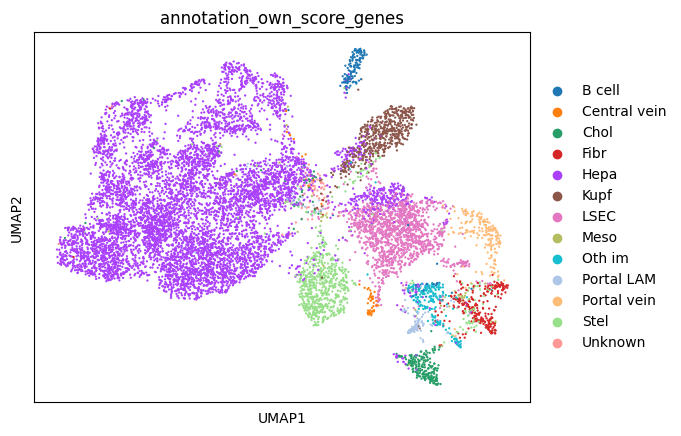

KeyboardInterrupt: 

In [43]:
# Own score genes iterative
scores = own_score_genes_iterative(sdata.table,path_mg,nr_iterations=8)

Hepa             8.669
LSEC             9.333
Portal vein      6.000
Central vein     8.500
Chol             7.500
Kupf            19.500
Stel            16.001
Fibr            17.625
B cell           4.500
Meso             6.000
Portal LAM      13.500
Oth im           4.000
dtype: float64


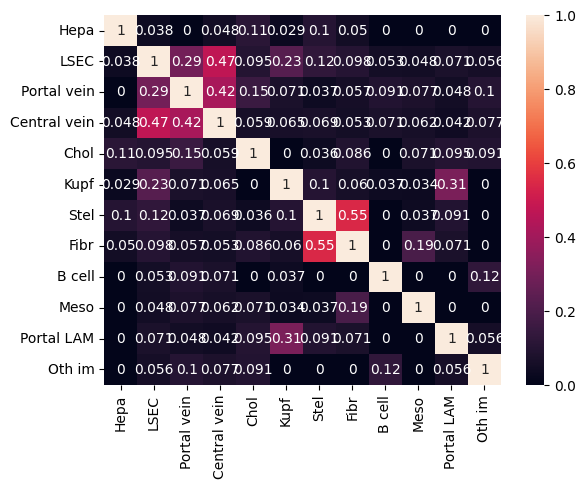

In [7]:
Jaccard_similarity_matrix(path_mg)

<AxesSubplot: >

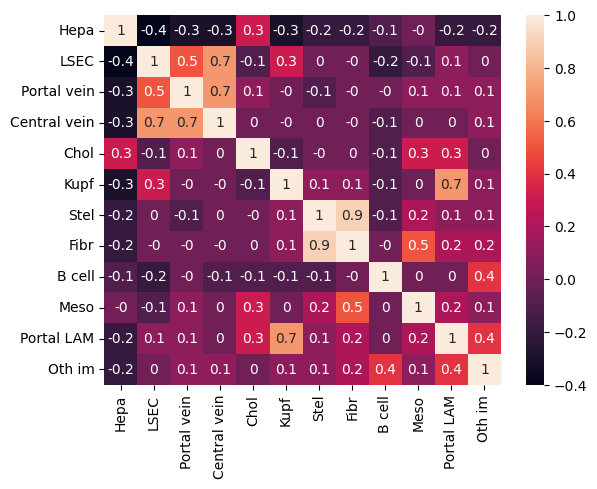

In [8]:
# plot correlation matrix of the features
sns.heatmap(np.round(scores.corr(method='pearson'),1), annot=True)
# sns.heatmap(scores_minmax.corr(method='pearson'), annot=True) gives the same heatmap

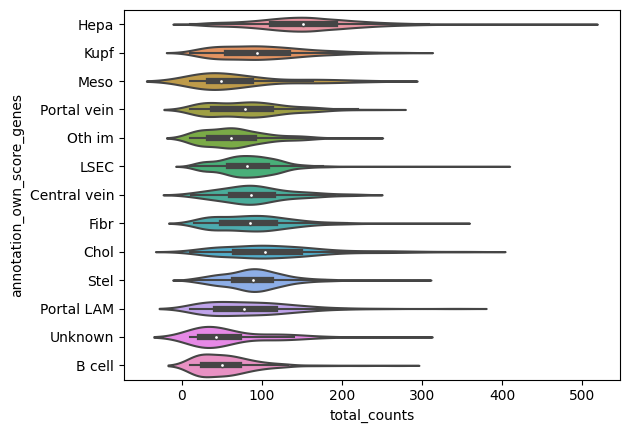

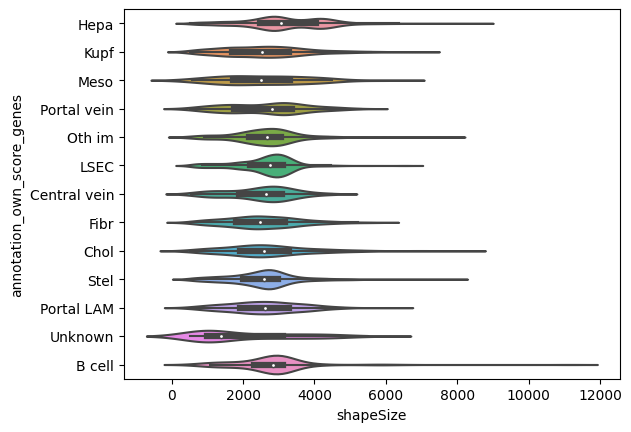

<AxesSubplot: xlabel='count_density', ylabel='annotation_own_score_genes'>

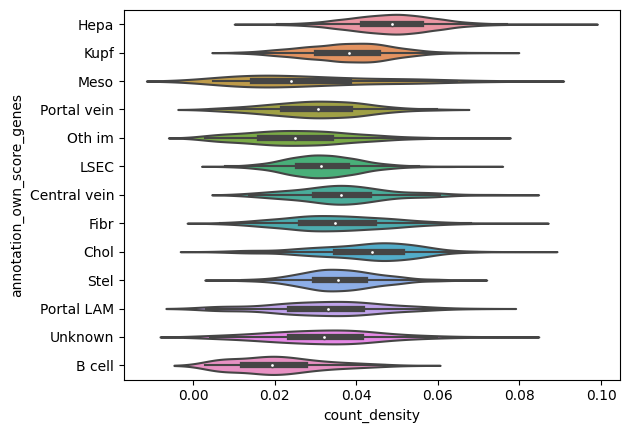

In [9]:
sns.violinplot(data=sdata.table.obs,x="total_counts",y="annotation_own_score_genes")
plt.show()
sns.violinplot(data=sdata.table.obs,x="shapeSize",y="annotation_own_score_genes")
plt.show()
sdata.table.obs['count_density'] = sdata.table.obs['total_counts'] / sdata.table.obs['shapeSize']
sns.violinplot(data=sdata.table.obs,x="count_density",y="annotation_own_score_genes")

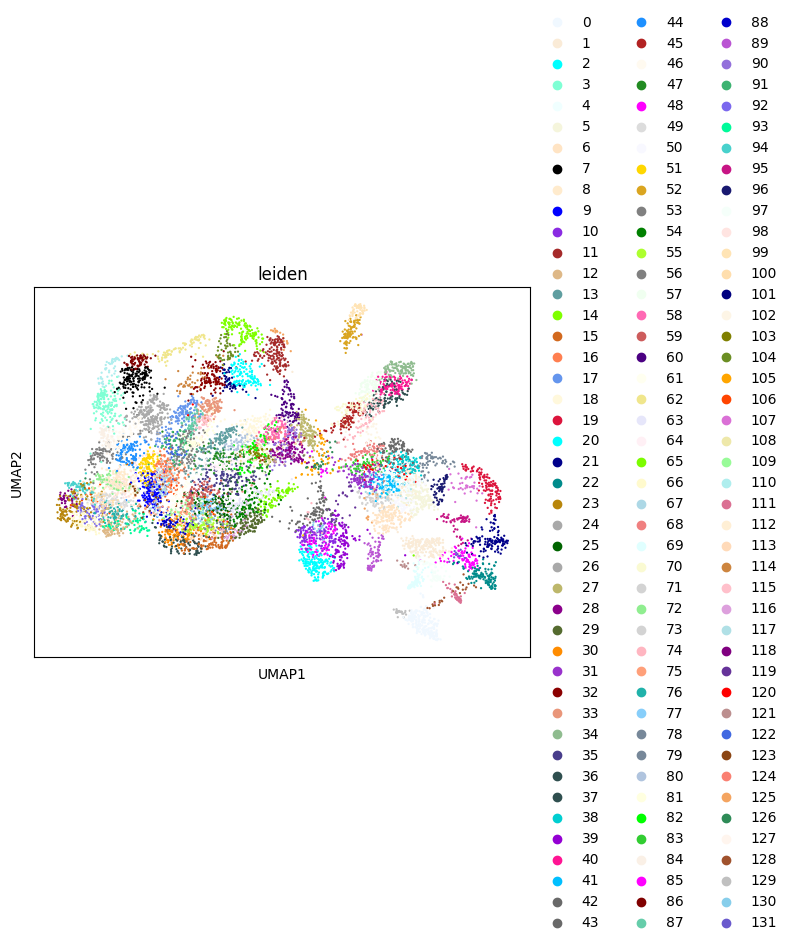

In [10]:
sc.tl.leiden(sdata.table,resolution=10,key_added='leiden')
sc.pl.umap(sdata.table,color='leiden',palette=list(matplotlib.colors.CSS4_COLORS.values()))

Index(['B cell', 'Central vein', 'Chol', 'Fibr', 'Hepa', 'Kupf', 'LSEC',
       'Meso', 'Oth im', 'Portal LAM', 'Portal vein', 'Stel', 'Unknown'],
      dtype='object')
Hepa
[3, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 20, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 35, 36, 44, 46, 47, 49, 51, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 72, 73, 75, 76, 77, 79, 80, 81, 82, 84, 86, 87, 88, 90, 91, 92, 93, 94, 98, 100, 101, 103, 104, 106, 108, 109, 110, 113, 114, 115, 116, 118, 122, 123, 124, 127]
Kupf
[34, 37, 40, 45, 57, 70, 74, 102]
LSEC
[4, 5, 6, 31, 38, 41, 43, 50, 71, 78, 83, 95, 96, 112, 117, 120]
Central vein
[89]
Portal vein
[19, 107]
Fibr
[21, 22, 48, 128, 131]
Stel
[2, 10, 39, 42, 85, 119, 130]
Meso
[]
Chol
[0, 129]
B cell
[52, 99]
Oth im
[1, 97]
Unknown
[105, 111, 121, 125, 126]
Portal LAM
[69]


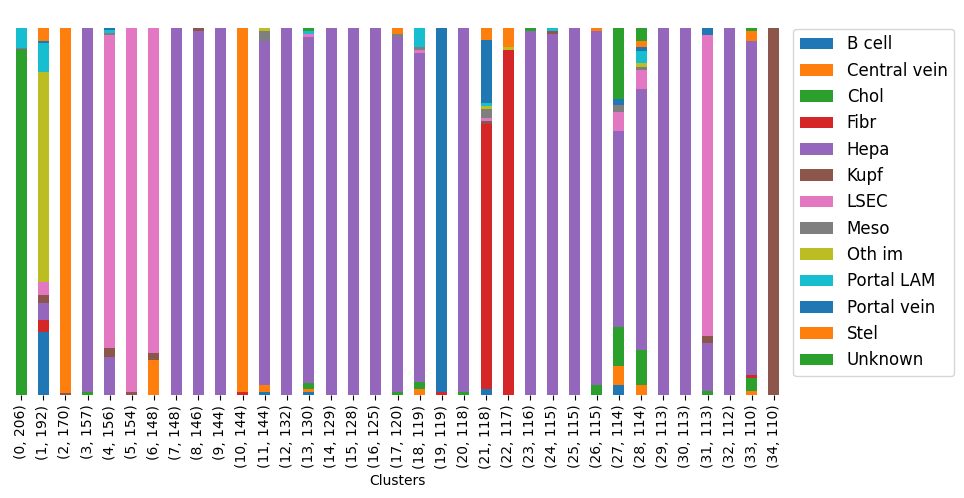

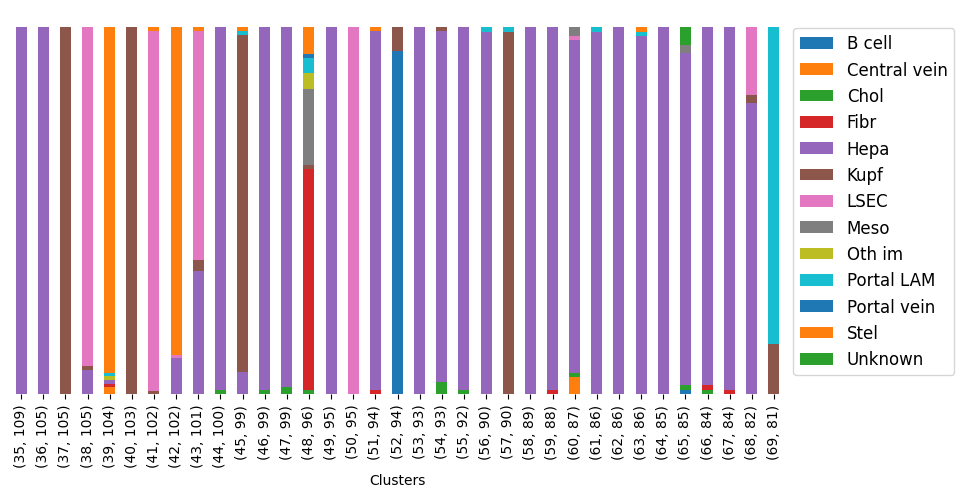

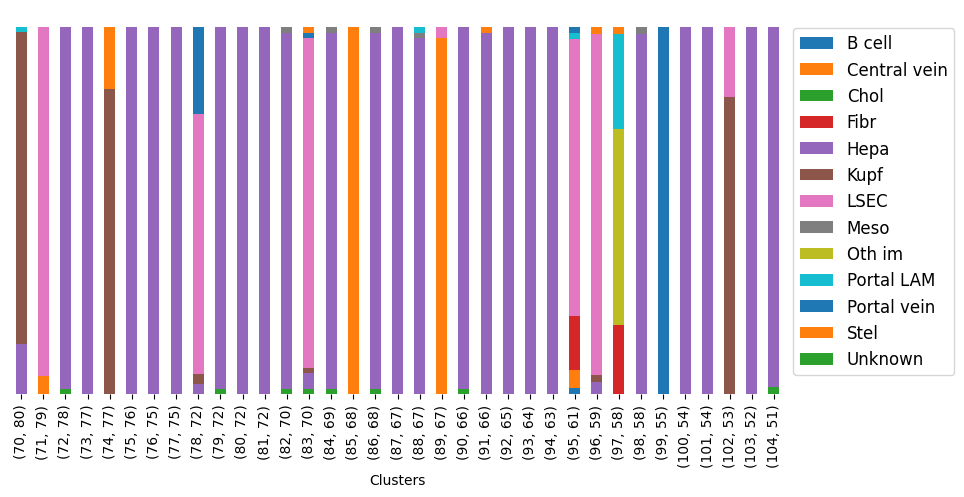

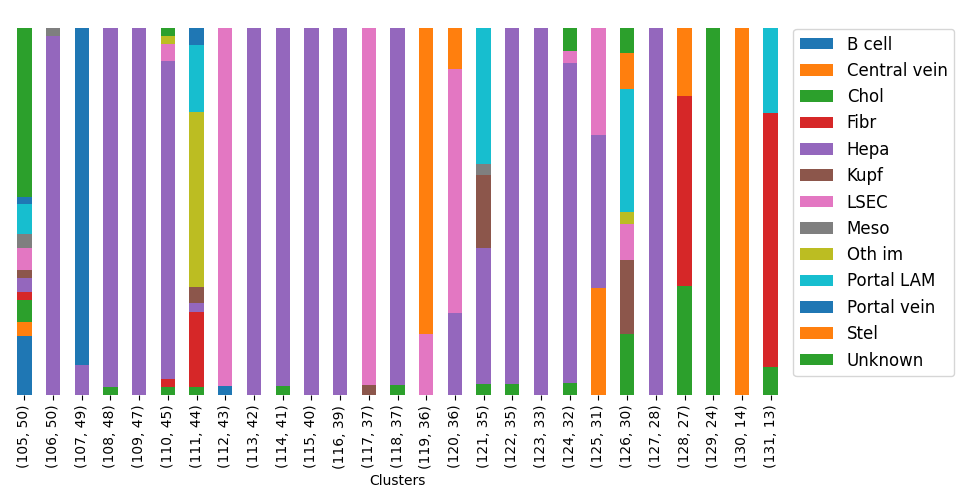

In [11]:
cell_types = ['Hepa','Kupf','LSEC','Central vein','Portal vein','Fibr','Stel','Meso','Chol','B cell','Oth im','Unknown','Portal LAM']
leiden_clusters_per_ct = clusteringVSleiden(sdata.table, "annotation_own_score_genes", "leiden",cell_types)

In [12]:
a = sdata.table.obs['leiden']
i = 0
for putative_leiden_clusters in leiden_clusters_per_ct:
    L = [str(x) for x in putative_leiden_clusters]
    for n in L:
        a = a.replace(n,cell_types[i])
    i += 1
sdata.table.obs['leiden_cell_types'] = a
print(sdata.table.obs['leiden_cell_types'].value_counts())


Hepa            6936
LSEC            1431
Kupf             717
Stel             638
Fibr             371
Oth im           250
Chol             230
Unknown          190
Portal vein      168
B cell           149
Portal LAM        81
Central vein      67
Name: leiden_cell_types, dtype: int64


67
Summary:
Hepa
Maybe drop:[['Glul', 'Central vein']]
Fibr
Maybe drop:[['Fn1', 'Hepa'], ['Plpp1', 'Central vein']]
Stel
Maybe drop:[['Fn1', 'Hepa'], ['Plpp1', 'Central vein']]
Chol
Maybe drop:[['Fn1', 'Hepa']]
Kupf
Maybe drop:[['Cd36', 'LSEC'], ['Plpp1', 'Central vein'], ['Pecam1', 'B cell'], ['C5ar1', 'Portal LAM'], ['Fcgr1', 'Portal LAM']]
LSEC
Maybe drop:[['Sirpa', 'Kupf'], ['Sirpa', 'Portal LAM']]
Central vein
Maybe drop:[['Cd9', 'Portal vein']]
Portal vein
Maybe drop:[['Plpp1', 'Central vein']]
Oth im
Maybe drop:[['Cd9', 'Portal vein']]
Portal LAM
Maybe drop:[['Cd9', 'Portal vein'], ['Spp1', 'Chol']]
B cell
Maybe drop:[['Itgb7', 'Oth im']]
Summary:
Hepa
Maybe drop:[['Glul', 'Central vein']]
Fibr
Maybe drop:[['Fn1', 'Hepa'], ['Plpp1', 'Central vein']]
Stel
Maybe drop:[['Fn1', 'Hepa'], ['Plpp1', 'Central vein'], ['Plpp1', 'Portal vein'], ['Axl', 'Fibr'], ['Lpl', 'Fibr']]
Kupf
Maybe drop:[['Cd36', 'LSEC'], ['Plpp1', 'Central vein'], ['Plpp1', 'Portal vein'], ['Plpp1', 'Fibr'], ['Pec

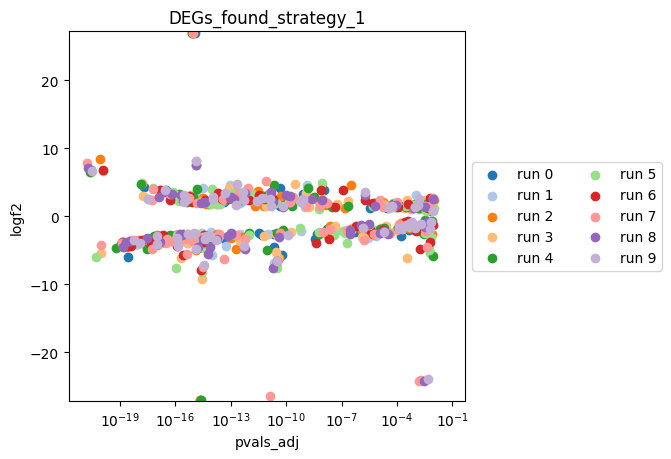

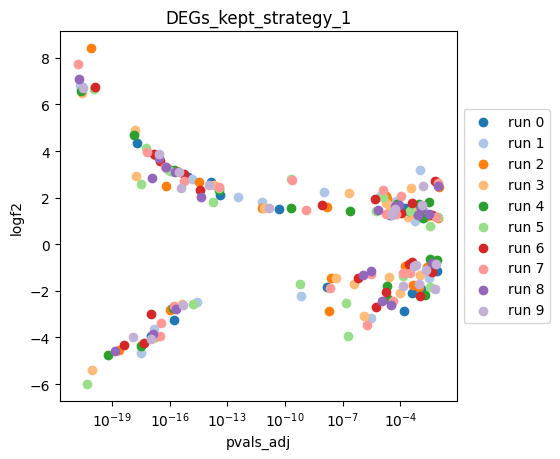

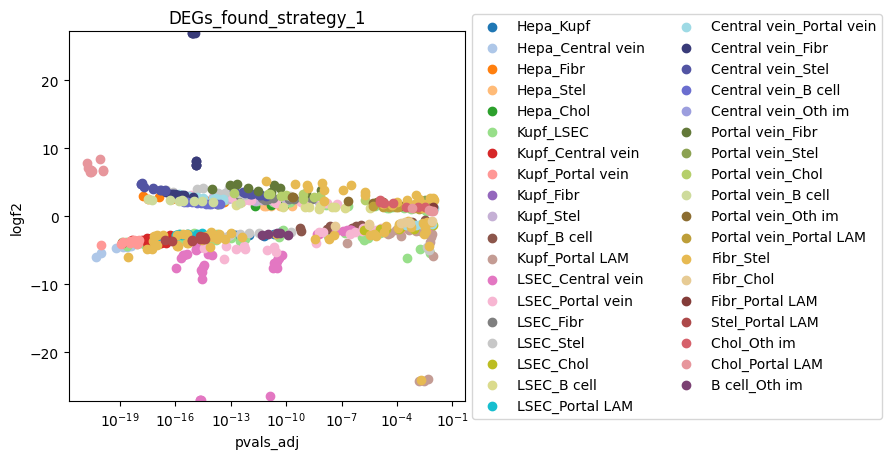

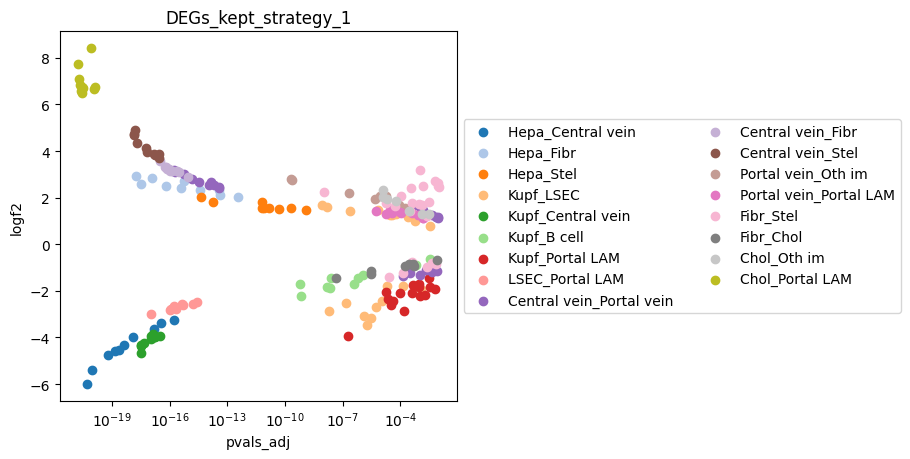

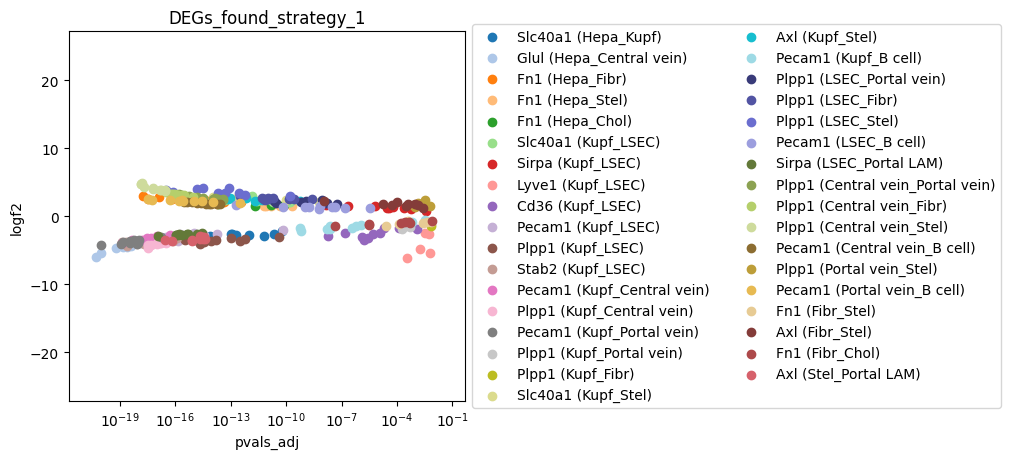

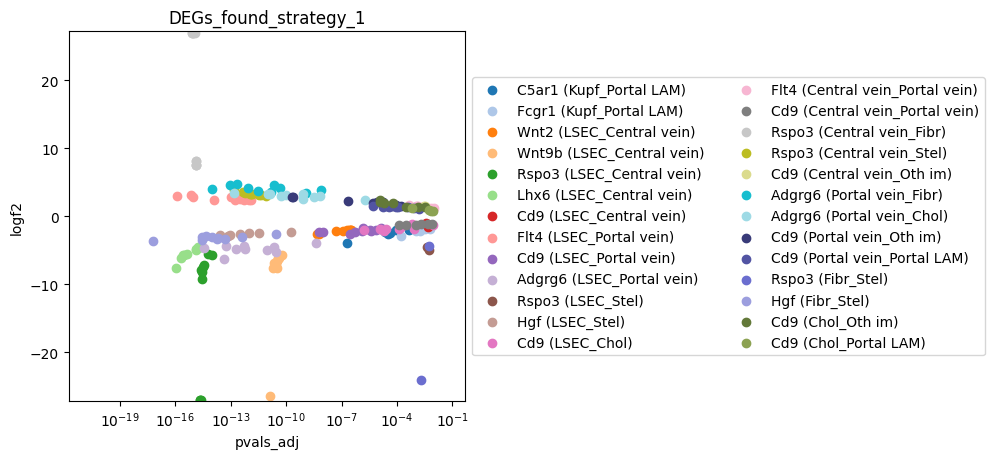

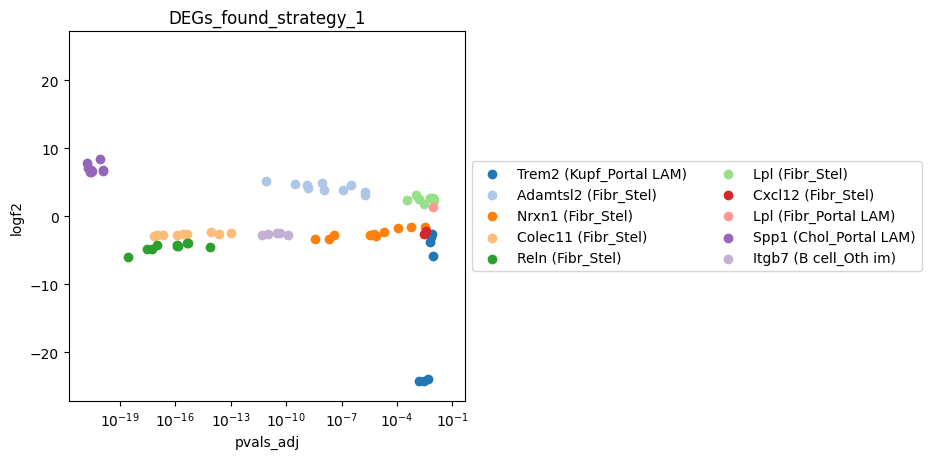

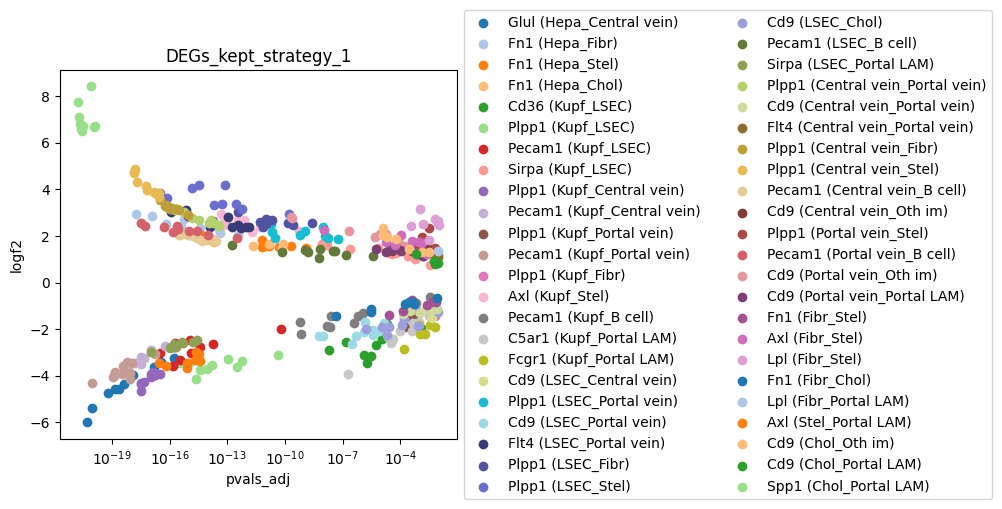

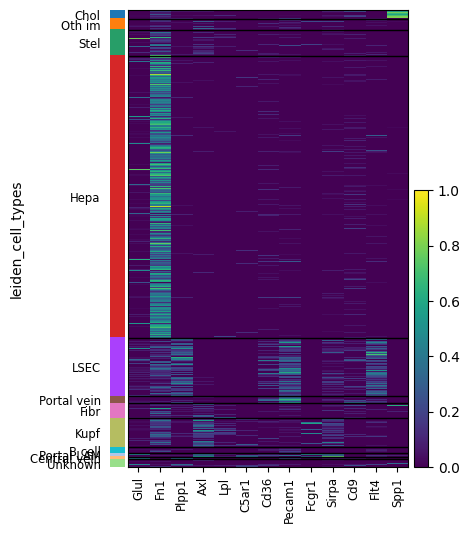

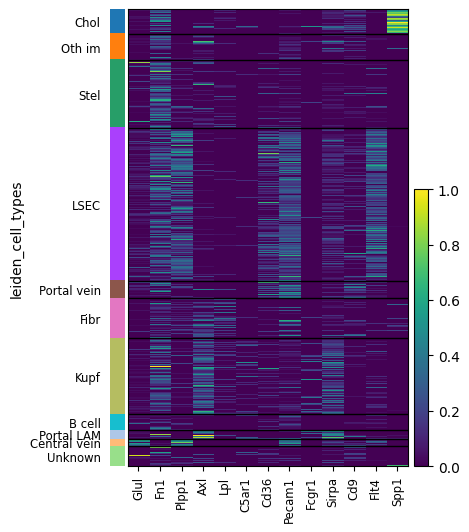

In [13]:
# STRATEGY 1 to change the marker gene list
results_strat1_10, results_runs1_10, DEG_details_runs1_10 = Apply_strategy_multiple_times(sdata.table,cell_types,leiden_clusters_per_ct,path_mg,10,1)

67
Ccr2
Is marker gene of: ['Portal LAM']
Could also be a marker gene of: ['Oth im']
Cd36
Is marker gene of: ['LSEC', 'Kupf']
Could also be a marker gene of: ['Portal vein']
Cd3e
Is marker gene of: []
Could also be a marker gene of: ['Oth im']
Clec10a
Is marker gene of: []
Could also be a marker gene of: ['Portal LAM']
Col1a1
Is marker gene of: ['Fibr']
Could also be a marker gene of: ['Portal LAM']
Cyp2e1
Is marker gene of: ['Hepa']
Could also be a marker gene of: ['LSEC', 'Central vein', 'Stel']
Dpt
Is marker gene of: ['Fibr']
Could also be a marker gene of: ['Portal LAM']
F13a1
Is marker gene of: []
Could also be a marker gene of: ['Portal LAM']
Gdf15
Is marker gene of: ['Kupf', 'Portal LAM']
Could also be a marker gene of: ['LSEC']
Ghr
Is marker gene of: ['Hepa']
Could also be a marker gene of: ['Stel']
Itgax
Is marker gene of: ['Oth im']
Could also be a marker gene of: ['Portal LAM']
Lilra5
Is marker gene of: ['Kupf']
Could also be a marker gene of: ['Portal LAM']
Mgl2
Is marker g

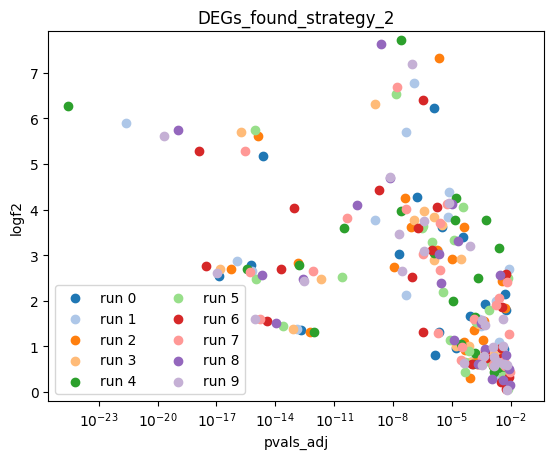

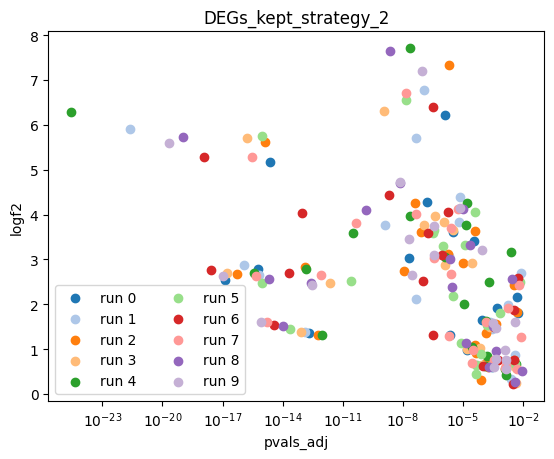

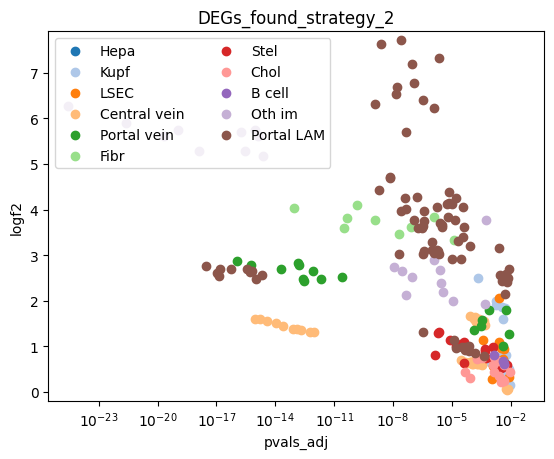

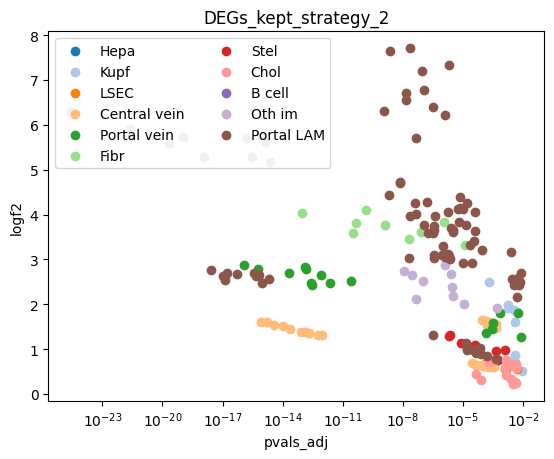

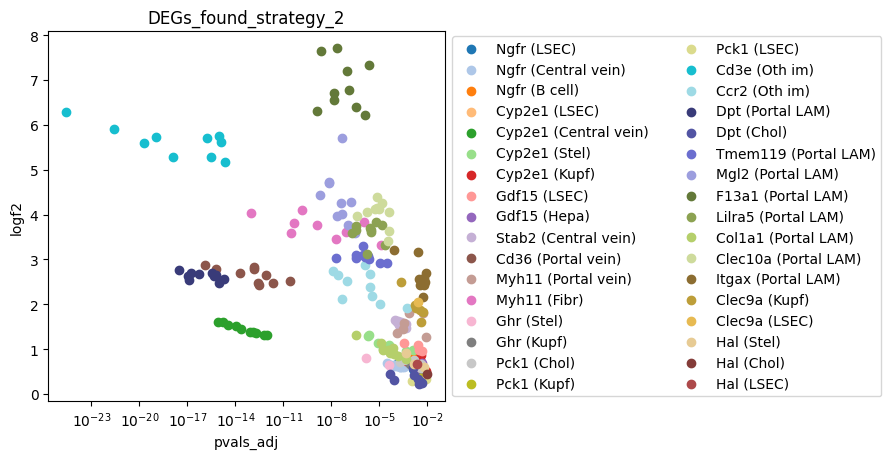

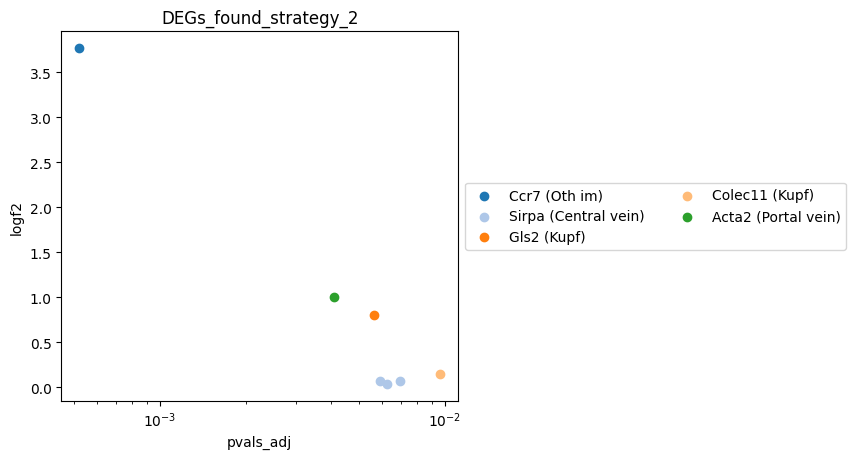

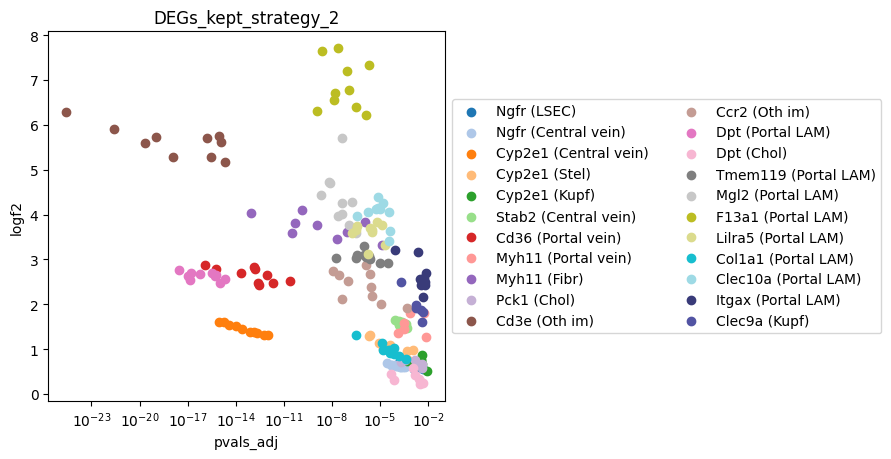

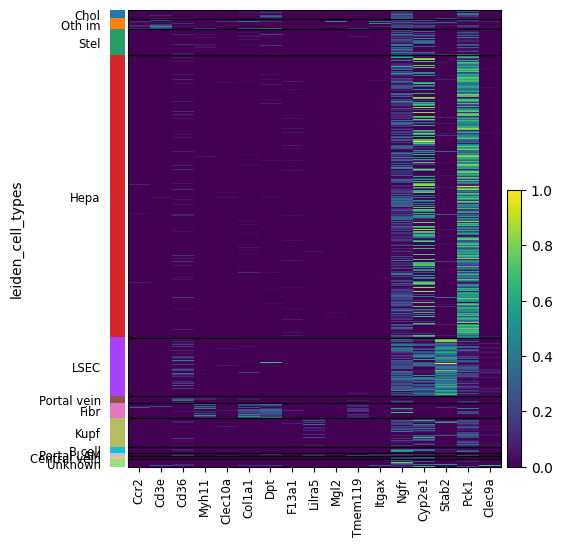

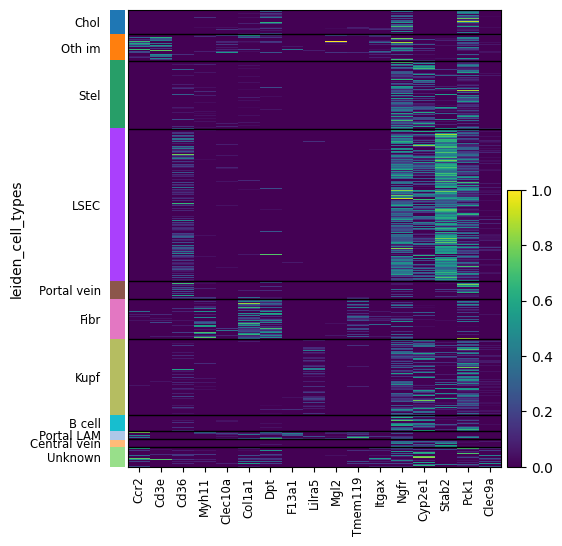

In [53]:
# STRATEGY 2 to change the marker gene list
results_strat2_10, results_runs2_10, DEG_details_runs2_10 = Apply_strategy_multiple_times(sdata.table,cell_types,leiden_clusters_per_ct,path_mg,10,2)

In [24]:
# Update marker gene list based on STRATEGY 1 and STRATEGY 2:
df_mg = pd.read_csv(path_mg,index_col=0)
keys = results_strat1_10.keys()
for key in keys:
    f = [x[0] for x in results_strat1_10[key]]
    f = np.unique(f).tolist()
    df_mg.loc[f,key] = 0
keys = results_strat2_10.keys()
for key in keys:
    df_mg.loc[results_strat2_10[key],key] = 1
path_mg_mod_1_2 = "/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/markerGeneListHL_othIm_modified_1_2.csv"
df_mg.to_csv(path_mg_mod_1_2)

In [ ]:
Jaccard_similarity_matrix(path_mg_mod_1_2)

Hepa            0.632704
LSEC            0.126113
Stel            0.062789
Kupf            0.048450
Fibr            0.025472
Chol            0.021197
Oth im          0.018525
Central vein    0.017991
Portal vein     0.017545
B cell          0.015497
Portal LAM      0.009441
Meso            0.004008
Unknown         0.000267
Name: annotation_own_score_genes_strat_1_2, dtype: float64


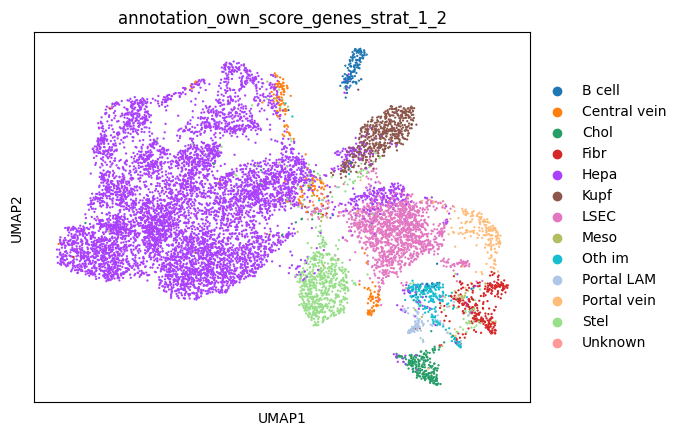

6.599572497328109


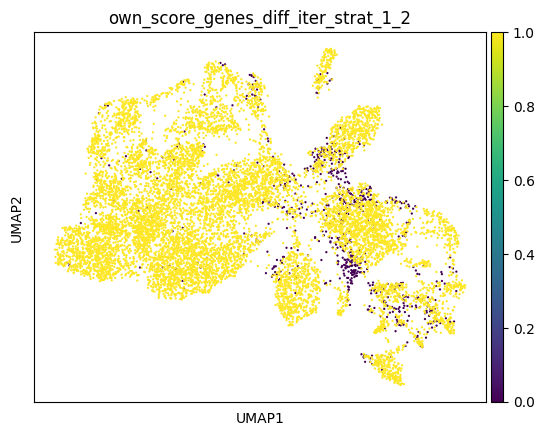

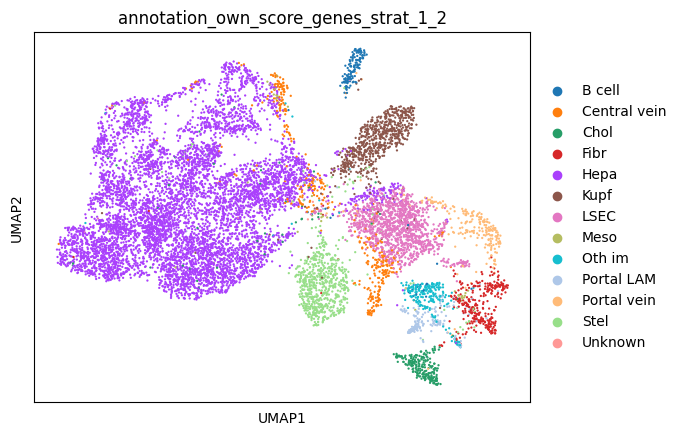

Hepa            0.603224
LSEC            0.113377
Kupf            0.060563
Stel            0.059405
Central vein    0.036694
Fibr            0.028322
Chol            0.025116
Oth im          0.020039
Portal vein     0.019950
Portal LAM      0.014695
B cell          0.014517
Meso            0.003830
Unknown         0.000267
Name: annotation_own_score_genes_strat_1_2, dtype: float64
1.0776629853936588


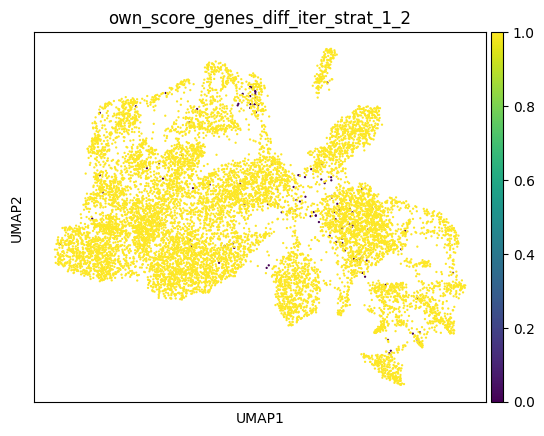

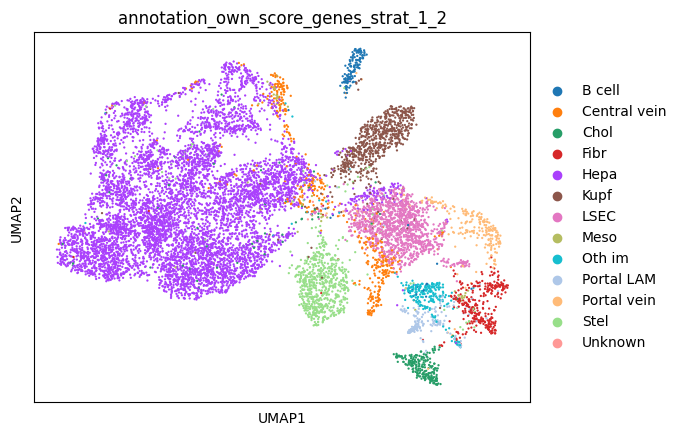

Hepa            0.598147
LSEC            0.110082
Kupf            0.061899
Stel            0.059761
Central vein    0.040702
Fibr            0.028589
Chol            0.026095
Oth im          0.020128
Portal vein     0.020128
Portal LAM      0.015497
B cell          0.014339
Meso            0.004364
Unknown         0.000267
Name: annotation_own_score_genes_strat_1_2, dtype: float64
0.16921980762379765


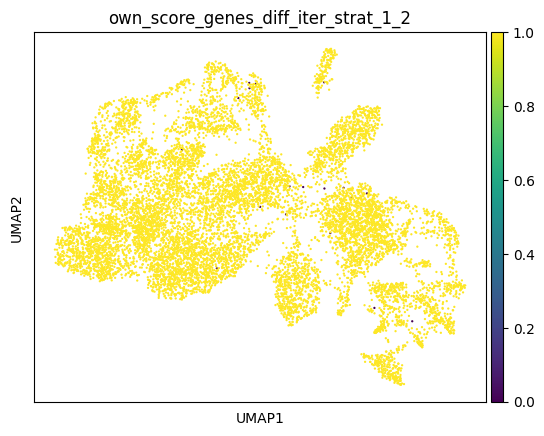

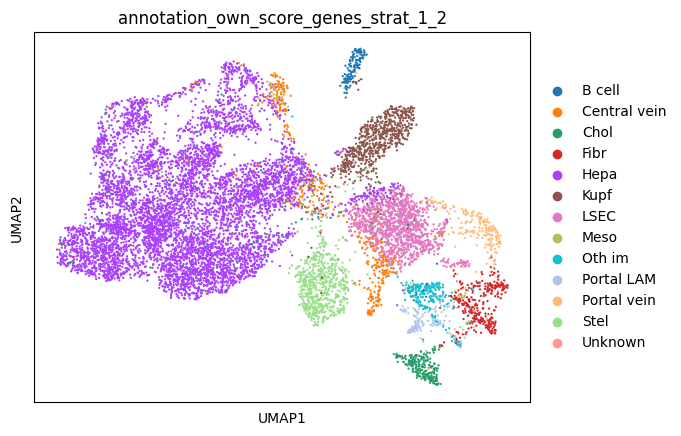

Hepa            0.597435
LSEC            0.109637
Kupf            0.062255
Stel            0.059761
Central vein    0.040791
Fibr            0.028500
Chol            0.026363
Portal vein     0.020128
Oth im          0.020039
Portal LAM      0.015764
B cell          0.014250
Meso            0.004809
Unknown         0.000267
Name: annotation_own_score_genes_strat_1_2, dtype: float64
0.035625222657641606


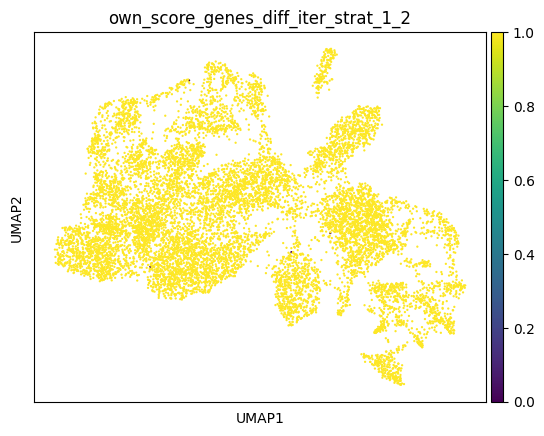

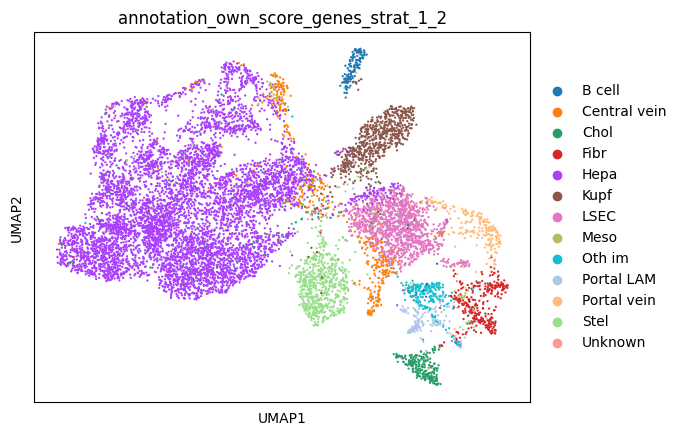

Hepa            0.597257
LSEC            0.109726
Kupf            0.062255
Stel            0.059672
Central vein    0.040702
Fibr            0.028589
Chol            0.026452
Portal vein     0.020128
Oth im          0.020039
Portal LAM      0.015764
B cell          0.014250
Meso            0.004898
Unknown         0.000267
Name: annotation_own_score_genes_strat_1_2, dtype: float64
converged


Hepa      LSEC  Portal vein  Central vein      Chol       Kupf  \
0      8.196705       NaN    -2.268198           NaN  2.757929  -4.547352   
1           NaN       NaN          NaN           NaN       NaN  18.775015   
2           NaN       NaN          NaN           NaN       NaN  -4.354912   
3      0.755296       NaN          NaN     -2.531995 -1.808325        NaN   
4      1.976390 -3.303210          NaN     -2.258976  0.348787        NaN   
...         ...       ...          ...           ...       ...        ...   
11223  3.684688 -2.827708          NaN     -3.063858  1.510945        NaN   
11224  8.143802 -3.010125          NaN     -1.105404  2.284861  -0.815046   
11225  4.281998       NaN          NaN           NaN  0.640920  -4.542645   
11226       NaN -0.279121          NaN     -2.853217       NaN  -1.053728   
11227  3.132049  0.008632    -1.738562     -0.385999 -0.887789  43.699976   

            Stel       Fibr    B cell       Meso  Portal LAM  Oth im  
0            NaN  -6.861768       NaN        NaN   -6.468710     NaN  
1            NaN   8.074081       NaN  14.161210   44.032471     NaN  
2            NaN   7.917992       NaN  19.947137   -2.404306     NaN  
3      -4.002550  -0.640532       NaN   5.185968   -5.770420     NaN  
4            NaN        NaN       NaN        NaN         NaN     NaN  
...          ...        ...       ...        ...         ...     ...  
11223        NaN        NaN       NaN        NaN   -7.786846     NaN  
11224  -1.325204        NaN       NaN        NaN   -2.736403     NaN  
11225        NaN        NaN       NaN        NaN   -5.935705     NaN  
11226  26.935409  14.615125       NaN        NaN   -6.522062     NaN  
11227  -1.788154  -3.779203 -2.015468  -1.484544   17.716994     NaN  

[11228 rows x 12 columns]

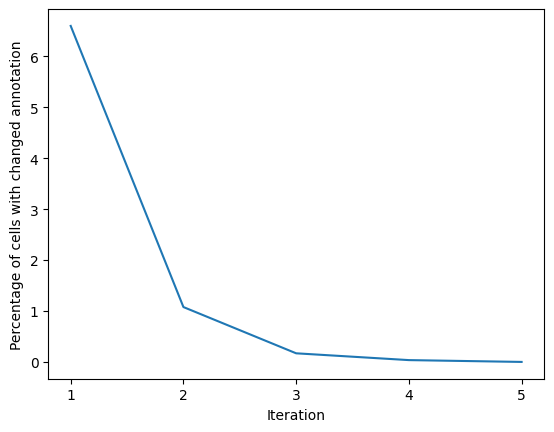

In [37]:
# Own score genes iterative with basic marker gene list updated with strategy 1 and 2
own_score_genes_iterative(sdata.table,path_mg_mod_1_2,nr_iterations=8,suffix='_strat_1_2')

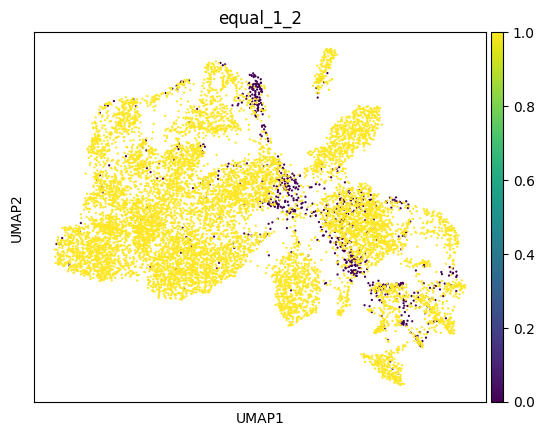

In [38]:
l = [sdata.table.obs['annotation_own_score_genes'].to_list()[i] == sdata.table.obs['annotation_own_score_genes_strat_1_2'].to_list()[i] for i in range(len(sdata.table.obs['annotation_own_score_genes'].to_list()))]
# list with True False to 0 1
sdata.table.obs['equal_1_2'] = [int(i) for i in l]
sc.pl.umap(sdata.table,color=['equal_1_2'])

In [39]:
sdata.table.obs.columns

Index(['region', 'instance', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes',
       'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize',
       'annotation_score_genes_25', 'cleanliness_score_genes_25',
       'score_celltype_own_score_genes',
       'second_score_celltype_own_score_genes', 'cleanliness_own_score_genes',
       'annotation_own_score_genes', 'count_density', 'leiden',
       'leiden_cell_types', 'score_celltype_own_score_genes_strat_1_2',
       'second_score_celltype_own_score_genes_strat_1_2',
       'cleanliness_own_score_genes_strat_1_2',
       'annotation_own_score_genes_strat_1_2', 'equal_1_2'],
      dtype='object')

In [ ]:
"test"